# Pnemonia Detection Challenge

<h1><center>Pneumonia Detection</center></h1>
<h3>Content:</h3>
<p>
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  project,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs
    </p>
     <h3>DATA DESCRIPTION:</h3>
    <p>
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data
    </p>
 </div>

In [1]:
!pip install pydicom

import pydicom as dcm
import cv2
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/rsna-pneumonia-detection-challenge.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [2]:
len(os.listdir('/tmp/stage_2_train_images'))

26684

## Milestone 1

### Process

#### Step 1. Import the data.

In [3]:
# importing labels info
labels_df = pd.read_csv("/content/drive/MyDrive/Capstone project - Pneumonia detection project/stage_2_train_labels.csv")
labels_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [4]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [5]:
labels_df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [6]:
labels_df.shape

(30227, 6)

In [7]:
# importing detailed class info
detailed_info_df = pd.read_csv("/content/drive/MyDrive/Capstone project - Pneumonia detection project/stage_2_detailed_class_info.csv")
detailed_info_df.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [8]:
detailed_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [9]:
detailed_info_df.isnull().sum()

patientId    0
class        0
dtype: int64

In [10]:
detailed_info_df.shape

(30227, 2)

In [11]:
# defining image path and counting the number of images we have in train image set
image_path = "/tmp/stage_2_train_images"
number_of_train_images = os.listdir(image_path)

print("Total images in train dataset: ", len(number_of_train_images))

Total images in train dataset:  26684


In [12]:
# defining test image path and counting the number of images we have in test image set
test_image_path = "/tmp/stage_2_test_images"
number_of_test_images = os.listdir(test_image_path)

print("Total test images in train dataset: ", len(number_of_test_images))

Total test images in train dataset:  3000


In [13]:
# sum up the train and test images
total_images = len(number_of_test_images) + len(number_of_train_images)
print("Total number of images(train+test): ", total_images)

Total number of images(train+test):  29684


#### Note -
Assuming all the labels and annotations are in the same CSV files for train set and test set. Because the sum of total images from train and test are very close to the total of detailed class info and labels CSV.

In [14]:
# importing submission sample
submission_sample_df = pd.read_csv("/content/drive/MyDrive/Capstone project - Pneumonia detection project/stage_2_sample_submission.csv")
submission_sample_df.head()

patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100

#### Step 2. Map training and testing images to its classes.

In [15]:
 # add another column image path to pnemonia dataframe to combine image paths with the classes
labels_df['image_path'] = ''

for i in range(len(labels_df)):
    patient_id = labels_df['patientId'][i]
    file_path = os.path.join(image_path, patient_id + '.dcm')
    labels_df['image_path'][i] = file_path

<ipython-input-15-22e00841d9c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['image_path'][i] = file_path


In [16]:
empty_imagepath_count = labels_df['image_path'].str.count('^$').sum()

print(f'Empty image count: {empty_imagepath_count}')

Empty image count: 0


In [17]:
labels_df.shape

(30227, 7)

In [18]:
labels_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                                          image_path  
0  /tmp/stage_2_train_images/0004cfab-14fd-4e49-8...  
1  /tmp/stage_2_train_images/00313ee0-9eaa-42f4-b...  
2  /tmp/stage_2_train_images/00322d4d-1c29-4943-a...  
3  /tmp/stage_2_train_images/003d8fa0-6bf1-40ed-b...  
4  /tmp/stage_2_train_images/00436515-870c-4b36-a...

In [19]:
# reading dicom data from the pneumonia dataframe
dicom_data = dcm.read_file(labels_df['image_path'][0])
print(dicom_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

#### Step 3. Map training and testing images to its annotations.

In [20]:
# mapping training and testing images with the annotations by combining labels_df and detailed_info_df
pneumonia_df = pd.merge(detailed_info_df, labels_df, on='patientId', how='inner')
pneumonia_df.shape

(37629, 8)

#### Note -
Looks like sum duplicate records come while merging, let's use unique records

In [21]:
pneumonia_df.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  \
0    NaN    NaN     NaN       0   
1    NaN    NaN     NaN       0   
2    NaN    NaN     NaN       0   
3    NaN    NaN     NaN       0   
4  152.0  213.0   379.0       1   

                                          image_path  
0  /tmp/stage_2_train_images/0004cfab-14fd-4e49-8...  
1  /tmp/stage_2_train_images/00313ee0-9eaa-42f4-b...  
2  /tmp/stage_2_train_images/00322d4d-1c29-4943-a...  
3  /tmp/stage_2_train_images/003d8fa0-6bf1-40ed-b...  
4  /tmp/stage_2_train_images/00436515-870c-4b36-a...

#### Step 4. Preprocessing and Visualisations of different classes.

In [22]:
pneumonia_df = pd.concat([detailed_info_df.drop(columns = 'patientId'), labels_df], axis = 1)

In [23]:
pneumonia_df.shape

(30227, 8)

In [24]:
pneumonia_df['patientId'].nunique()

26684

<Axes: xlabel='Target', ylabel='Count'>

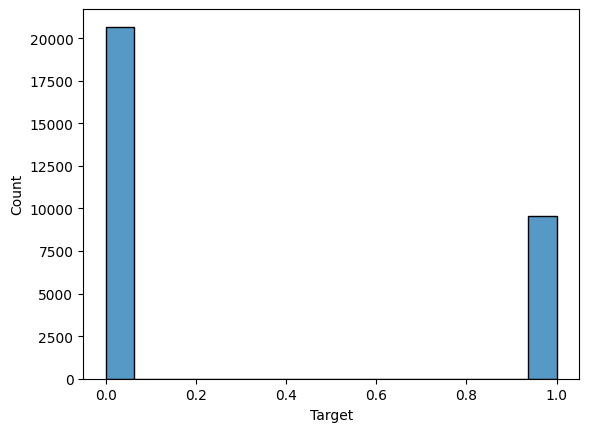

In [25]:
sns.histplot(data = pneumonia_df['Target'])

In [26]:
pneumonia_df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

We have an imbalance in the target data.

Class 0 - Normal, No Lung Opacity/Not Normal - 20672

Class 1 - Lung Opacity - 9555

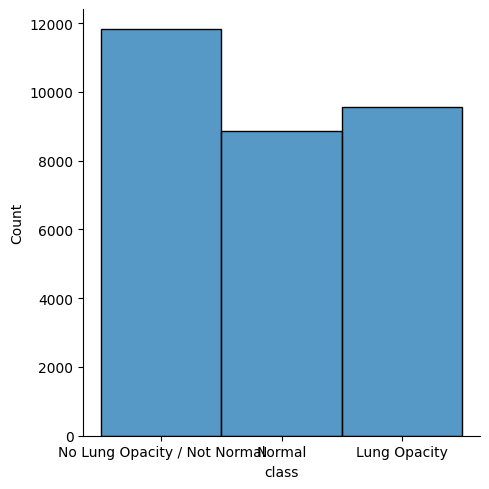

In [27]:
sns.displot(data=pneumonia_df, x="class")

In [28]:
pneumonia_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

The above clearly shows that the dataset is imbalanced. We can use data augmentation techniques to make a balanced dataset.

In [29]:
# converting the image to a pixel values and resizing the array values.

resized_images = []
boxes = []
for i in tqdm(range(len(pneumonia_df))):
    patient_id = pneumonia_df['patientId'][i]
    image_path = pneumonia_df['image_path'][i]
    target = pneumonia_df['Target'][i]
    dicom_data = dcm.read_file(image_path)
    img = dicom_data.pixel_array

    # Resize image to 224x224
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized_images.append(img)
    boxes.append(np.array(target, dtype=np.float32))

  0%|          | 0/30227 [00:00<?, ?it/s]

In [30]:
len(resized_images)

30227

In [31]:
resized_images[0].shape

(224, 224, 3)

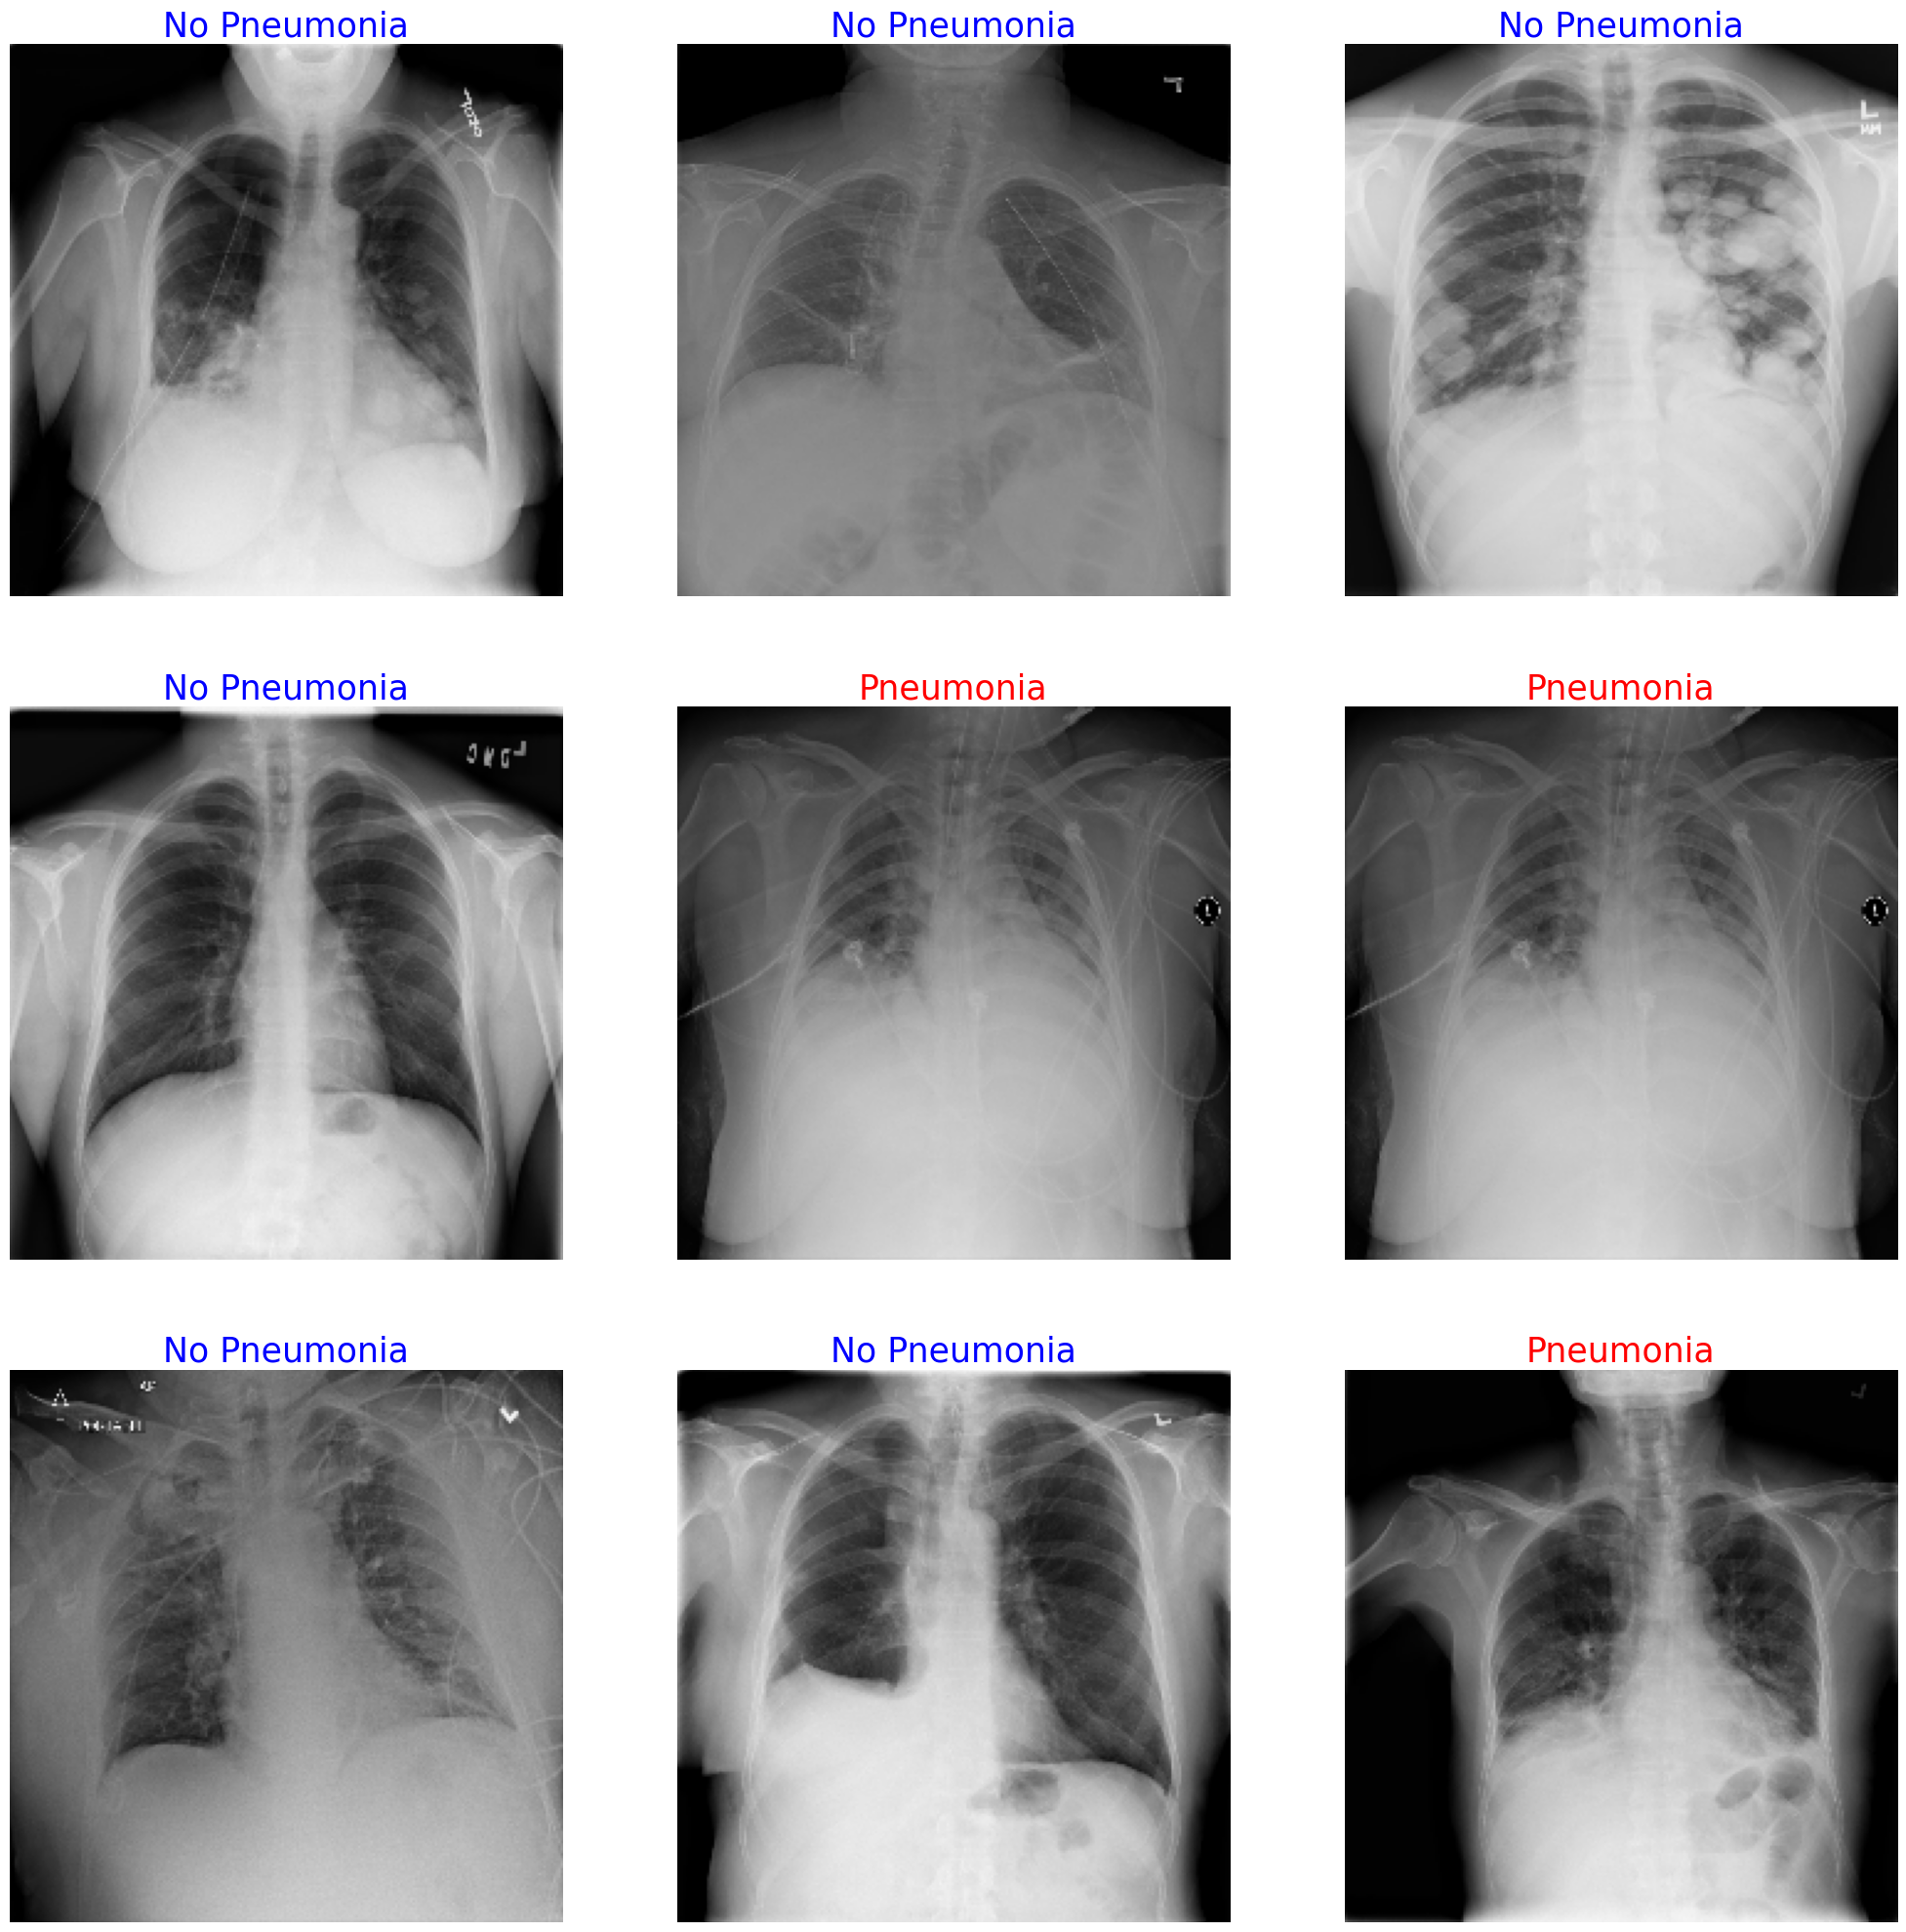

In [32]:
plt.figure(figsize=(25,25)) #
for i, image in enumerate(resized_images[:9]):

    plt.subplot(3,3,i+1)
    plt.imshow(image)
    if pneumonia_df.loc[i]["Target"]:
        plt.title("Pneumonia", color="red", fontsize=25)
    else:
        plt.title("No Pneumonia", color="blue", fontsize=25)
    plt.axis('off')
plt.show()

#### Step 5. Display images with bounding box.

In [33]:
resized_images_1 = resized_images.copy()

In [34]:
len(resized_images_1)

30227

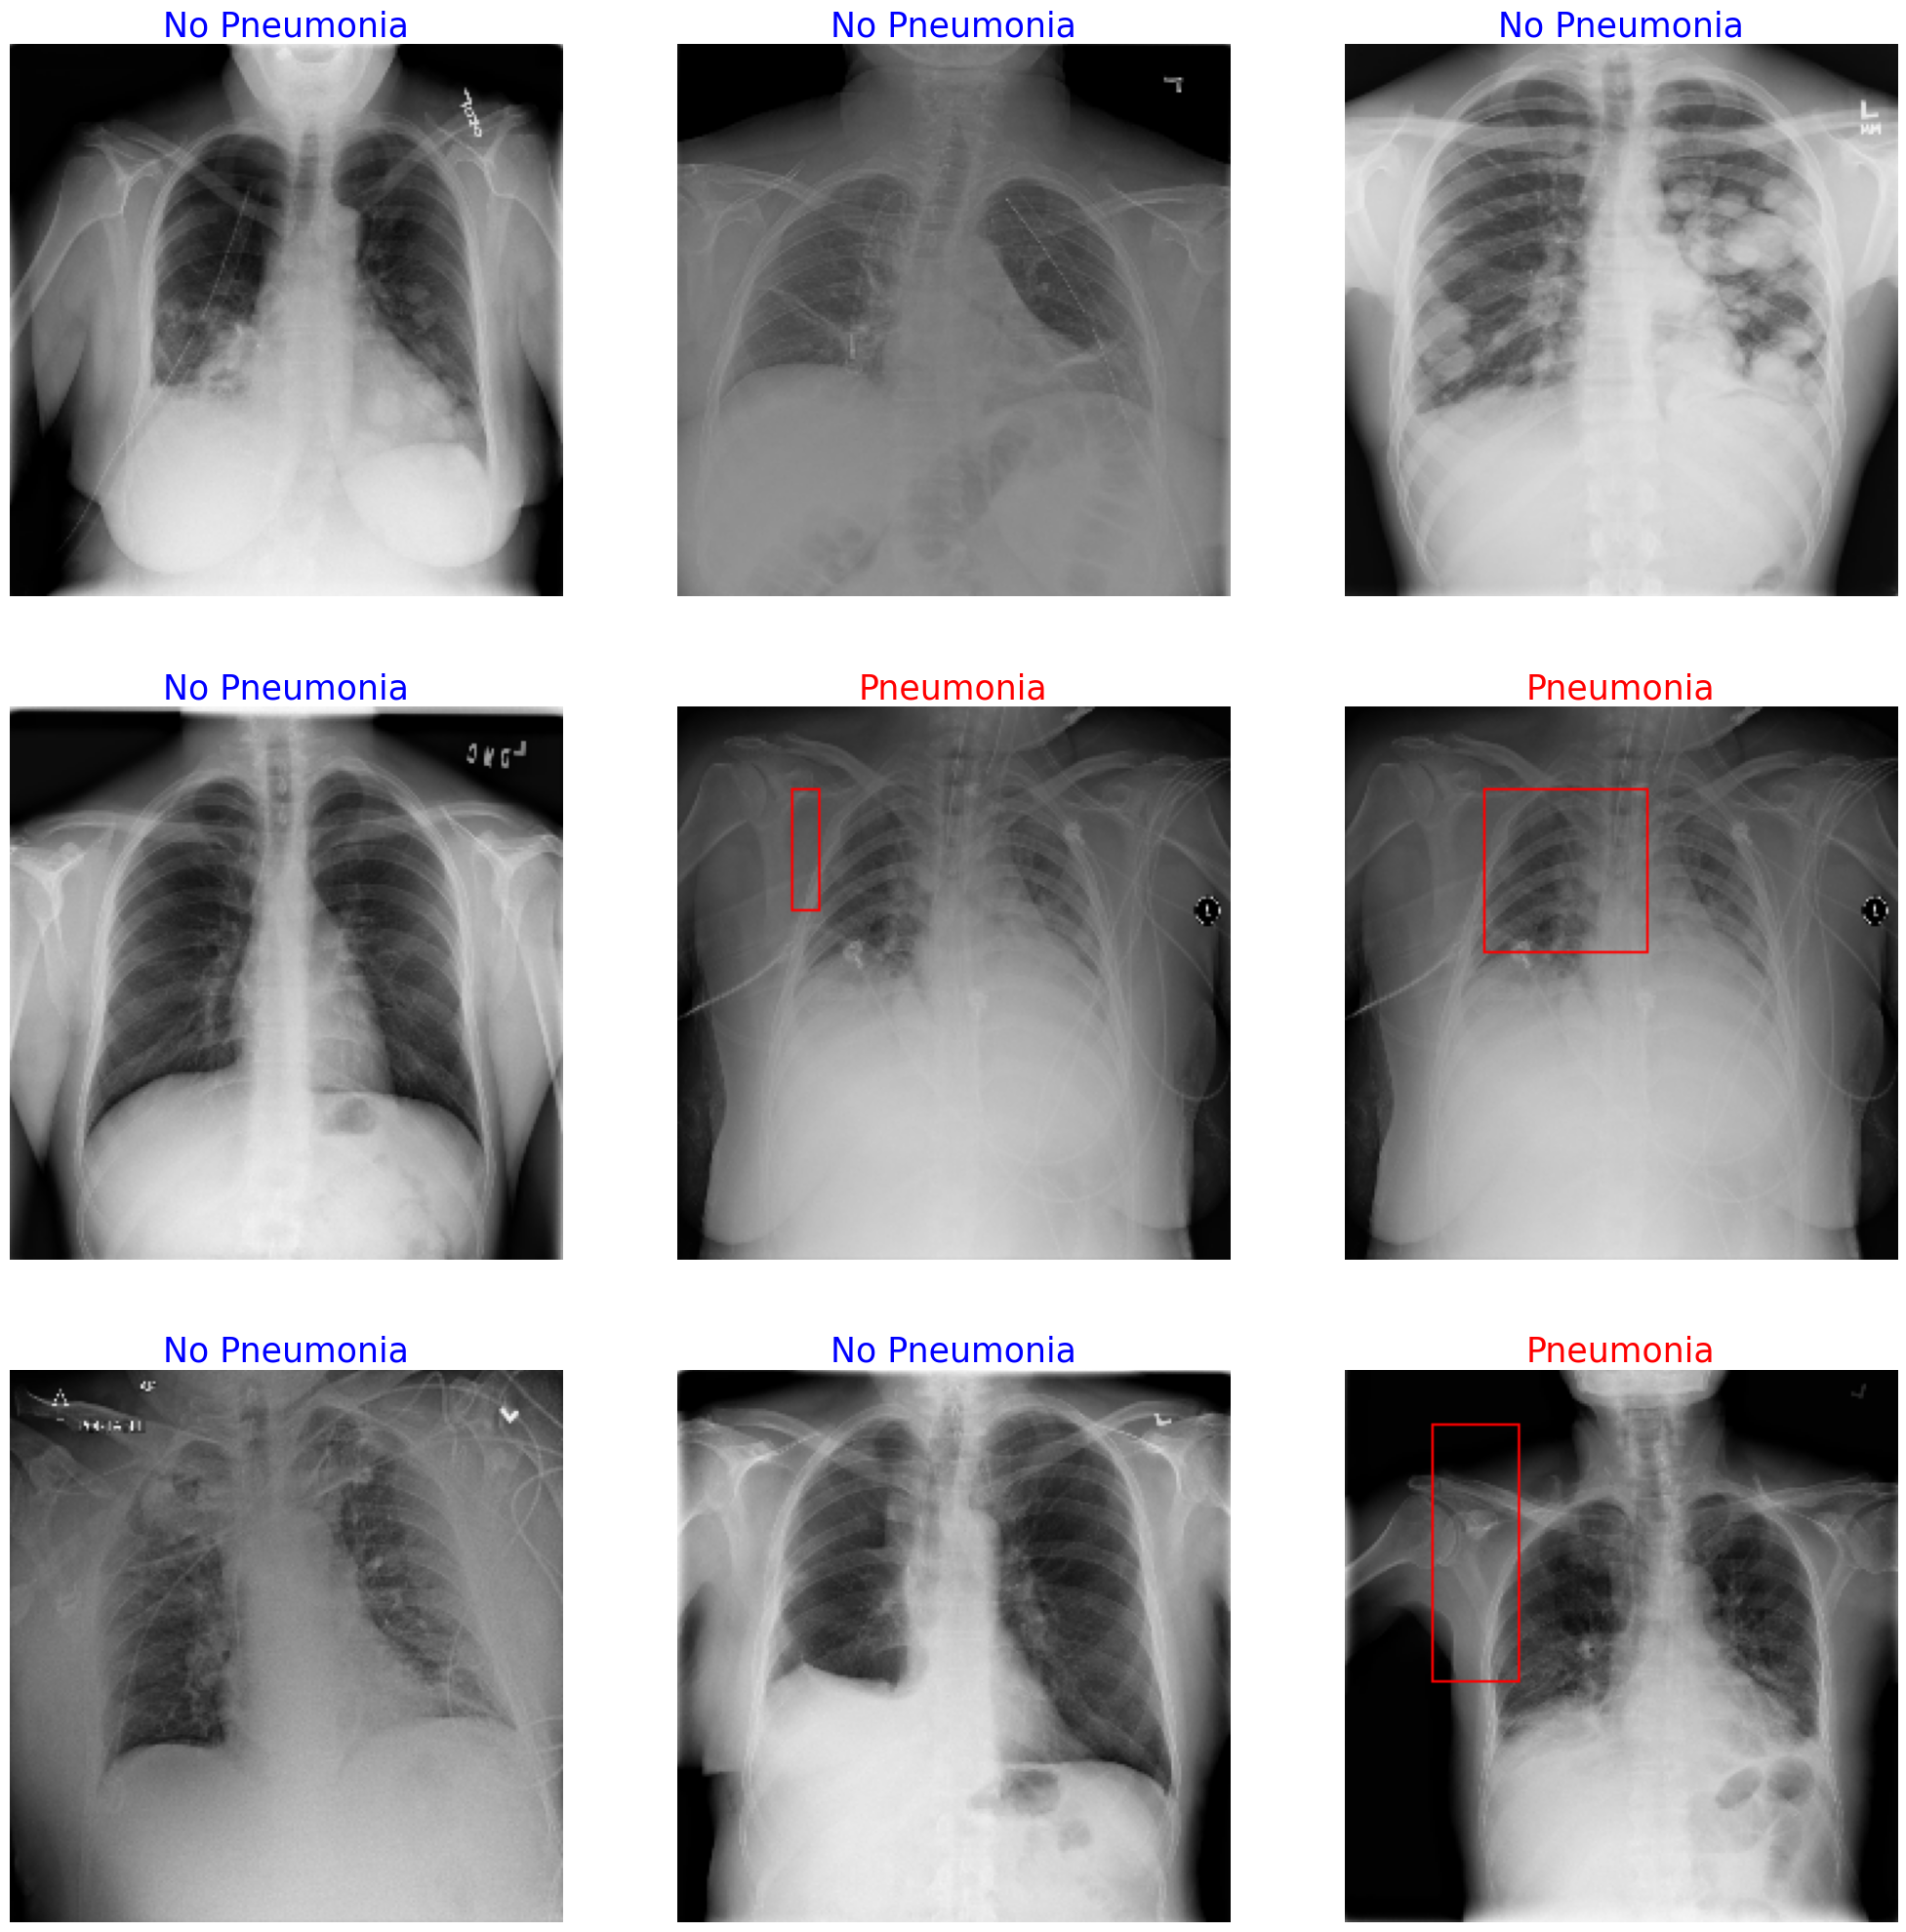

In [35]:
plt.figure(figsize=(25,25)) #
for i, image in enumerate(resized_images_1[:9]):
    x1 = pneumonia_df['x'][i]
    y1 = pneumonia_df['y'][i]
    x2 = pneumonia_df['width'][i]
    y2 = pneumonia_df['height'][i]
    plt.subplot(3,3,i+1)
    if np.isnan(x1):
      #print(1)
      plt.imshow(image)
    else:
      #print(2)
      pt1=int(x1*(224.0/1024.0)),int(y1*(224.0/1024.0))
      pt2=int(x2*(224.0/1024.0)),int(y2*(224.0/1024.0))
      image = cv2.rectangle(image,pt1,pt2, color=(255,0,0), thickness = 1)
      plt.imshow(image)

    if pneumonia_df.loc[i]["Target"]:
        plt.title("Pneumonia", color="red", fontsize=25)
    else:
        plt.title("No Pneumonia", color="blue", fontsize=25)
    plt.axis('off')
plt.show()

#### Step 6. Design, train and test basic CNN models for classification.

In [36]:
X_train = resized_images[:20000]
X_test = resized_images[20000:30000]
y_train = np.array(boxes[:20000])
y_test = np.array(boxes[20000:30000])

In [37]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

20000 20000
10000 10000


In [38]:
unique_values = set(np.array(y_train))
len(unique_values)

2

In [39]:
cnt = 0
cnt1 =0
for i in range(len(y_train)):
  if y_train[i] == 0:
    cnt = cnt+1
  else:
    cnt1 =cnt1+1

print(cnt, cnt1)

13346 6654


Base Model : Resnet

Data : ImBalanced dataset

In [41]:
X_train = np.array(X_train,dtype=np.float32)
X_train = X_train / 255.0

In [42]:
X_test = np.array(X_test,dtype=np.float32)
X_test = X_test / 255.0

In [43]:
type(X_train)

numpy.ndarray

In [44]:
y_train[0]

0.0

In [45]:
X_train.shape

(20000, 224, 224, 3)

In [46]:
y_train[1]

0.0

In [47]:
# Load the pre-trained ResNet50 model with weights from ImageNet
base_model_resnet = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg')

# freeze some of the top layers
for layer in base_model_resnet.layers[:-10]:
    layer.trainable = False

# Create your custom classifier on top of the pre-trained model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(BatchNormalization())

# Add more layers as needed
model_resnet.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation(activation='relu'))
model_resnet.add(Dropout(0.3))

# Add the final output layer
model_resnet.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model_resnet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0

In [48]:
# Compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate
model_resnet.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [49]:
# Fine-tuning the model on the data
history_resnet = model_resnet.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
500/500 [==============================] - 34s 35ms/step - loss: 3.6497 - accuracy: 0.7268 - val_loss: 2.5634 - val_accuracy: 0.7157
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 1.9009 - accuracy: 0.7639 - val_loss: 1.5265 - val_accuracy: 0.7322
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 1.1838 - accuracy: 0.7707 - val_loss: 1.5116 - val_accuracy: 0.5805
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.8459 - accuracy: 0.7791 - val_loss: 0.9462 - val_accuracy: 0.7178
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.6754 - accuracy: 0.7832 - val_loss: 0.8094 - val_accuracy: 0.6837
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.5865 - accuracy: 0.7875 - val_loss: 1.2672 - val_accuracy: 0.5717
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.5383 - accuracy: 0.7952 - val_loss: 0.6162 - val_accuracy:

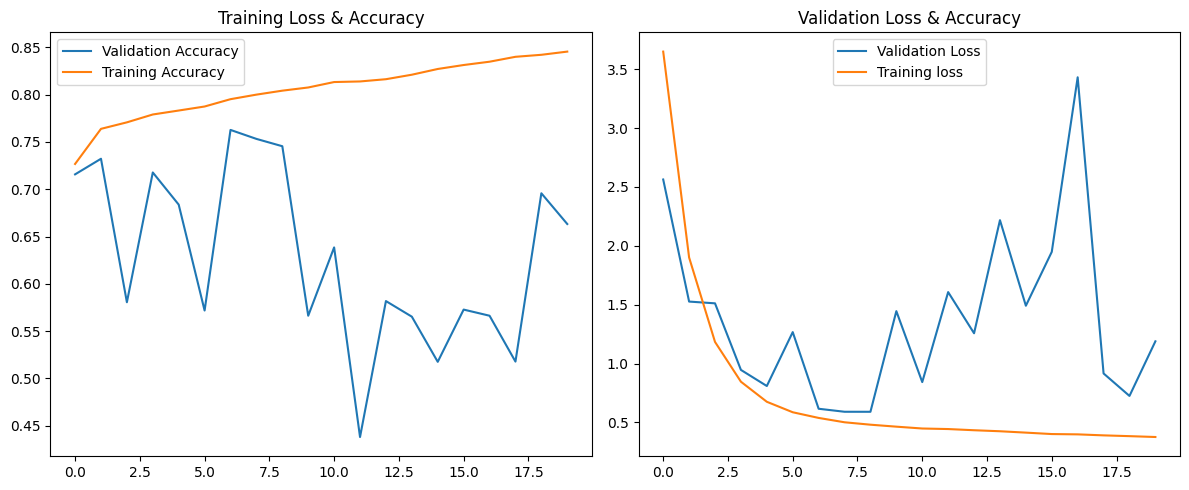

In [50]:
# Create a single figure with two subplots, arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss and validation loss in the first subplot
ax1.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
ax1.plot(history_resnet.history['accuracy'], label='Training Accuracy')
ax1.set_title('Training Loss & Accuracy')
ax1.legend()

# Plot training accuracy and validation accuracy in the second subplot
ax2.plot(history_resnet.history['val_loss'], label='Validation Loss')
ax2.plot(history_resnet.history['loss'], label='Training loss')
ax2.set_title('Validation Loss & Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Balanced dataset using data augmentation techniques

In [51]:
# good for balancing out disproportions in the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [52]:
history_resnet_1 = model_resnet.fit(datagen.flow(X_train[:6000], y_train[:6000], batch_size=10), epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
600/600 [==============================] - 79s 127ms/step - loss: 0.6725 - accuracy: 0.6848 - val_loss: 0.7159 - val_accuracy: 0.7278
Epoch 2/10
600/600 [==============================] - 66s 110ms/step - loss: 0.6271 - accuracy: 0.7027 - val_loss: 0.6184 - val_accuracy: 0.7310
Epoch 3/10
600/600 [==============================] - 66s 110ms/step - loss: 0.6120 - accuracy: 0.6993 - val_loss: 0.5765 - val_accuracy: 0.7211
Epoch 4/10
600/600 [==============================] - 66s 109ms/step - loss: 0.6046 - accuracy: 0.7117 - val_loss: 0.6513 - val_accuracy: 0.7301
Epoch 5/10
600/600 [==============================] - 66s 110ms/step - loss: 0.5987 - accuracy: 0.7160 - val_loss: 0.6883 - val_accuracy: 0.6222
Epoch 6/10
600/600 [==============================] - 66s 110ms/step - loss: 0.5985 - accuracy: 0.7097 - val_loss: 1.4719 - val_accuracy: 0.3914
Epoch 7/10
600/600 [==============================] - 66s 109ms/step - loss: 0.5960 - accuracy: 0.7120 - val_loss: 0.7094 - val_ac

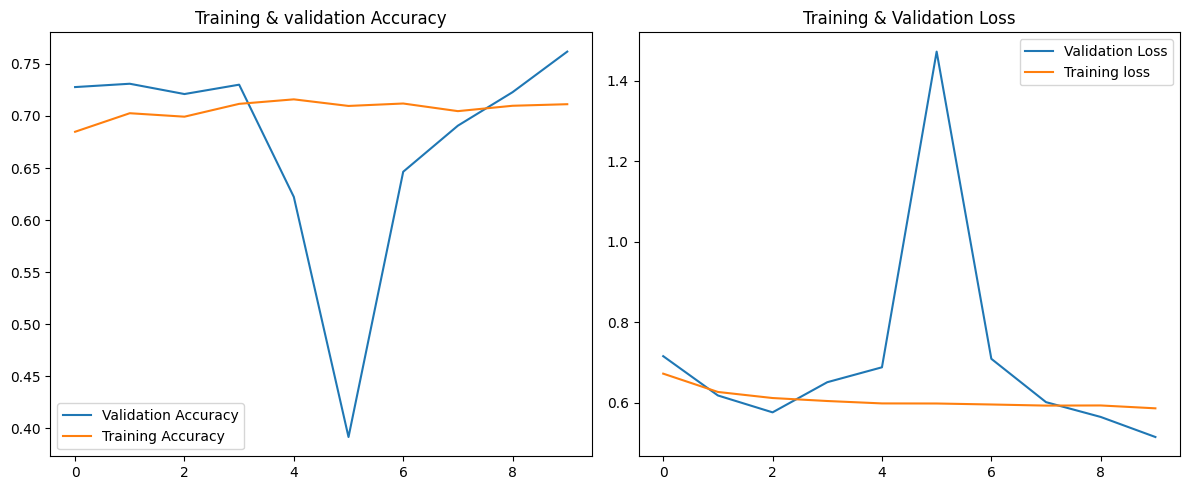

In [53]:
# Create a single figure with two subplots, arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss and validation loss in the first subplot
ax1.plot(history_resnet_1.history['val_accuracy'], label='Validation Accuracy')
ax1.plot(history_resnet_1.history['accuracy'], label='Training Accuracy')
ax1.set_title('Training & validation Accuracy')
ax1.legend()

# Plot training accuracy and validation accuracy in the second subplot
ax2.plot(history_resnet_1.history['val_loss'], label='Validation Loss')
ax2.plot(history_resnet_1.history['loss'], label='Training loss')
ax2.set_title('Training & Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()

####Conclusion
Model Accuracy is looks good on the sample data. We used only 20000 total records for this project with A100 GPU

Model Accuracy is ~84.5% <br />
Model Validation Accuracy is ~66%

Validation accuracy is pretty low, we will further tune this model to get better accuracy.

With the augmented datasets, the model validation accuracy moves to 71%, but at the same time the training has come down to 76%. But it also says the model predicting capability has improved.

#### Step 7. Intrim Report.

Intrim report is attached as a document.

## Milestone 2

### Process

#### Step 1. Fine tune the trained basic CNN models for classification.

In [54]:
# Using ResNet50 as a base model
tuned_base_model_resnet = ResNet50(weights = 'imagenet', input_shape = (224,224,3) , include_top=False, pooling='avg' )
for l in tuned_base_model_resnet.layers[:-4]:

    l.trainable=False

In [55]:
tuned_model_resnet = Sequential()
tuned_model_resnet.add(base_model_resnet)
tuned_model_resnet.add(BatchNormalization())


tuned_model_resnet.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
tuned_model_resnet.add(BatchNormalization())
tuned_model_resnet.add(Activation(activation='relu'))

tuned_model_resnet.add(Dropout(0.3))



tuned_model_resnet.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
tuned_model_resnet.add(BatchNormalization())
tuned_model_resnet.add(Activation(activation='relu'))

tuned_model_resnet.add(Dropout(0.3))

tuned_model_resnet.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
tuned_model_resnet.add(BatchNormalization())
tuned_model_resnet.add(Activation(activation='relu'))

tuned_model_resnet.add(Dropout(0.3))


tuned_model_resnet.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
tuned_model_resnet.add(BatchNormalization())
tuned_model_resnet.add(Activation(activation='relu'))

tuned_model_resnet.add(Dropout(0.3))


tuned_model_resnet.add(Dense(16, kernel_regularizer=regularizers.l2(0.01)))
tuned_model_resnet.add(BatchNormalization())
tuned_model_resnet.add(Activation(activation='relu'))

tuned_model_resnet.add(Dropout(0.3))

tuned_model_resnet.add(Dense(1, activation = 'sigmoid'))

In [56]:
tuned_model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [57]:
#optimizer = Adam(learning_rate=0.00001)
tuned_model_resnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tuned_history_resnet = tuned_model_resnet.fit(datagen.flow(X_train[:6000], y_train[:6000], batch_size=10), epochs = 10, validation_data=(X_test[:6000], y_test[:6000]))

Epoch 1/10
600/600 [==============================] - 77s 113ms/step - loss: 3.6876 - accuracy: 0.6208 - val_loss: 2.2882 - val_accuracy: 0.3802
Epoch 2/10
600/600 [==============================] - 64s 107ms/step - loss: 1.4149 - accuracy: 0.6742 - val_loss: 1.1451 - val_accuracy: 0.5830
Epoch 3/10
600/600 [==============================] - 64s 106ms/step - loss: 0.8913 - accuracy: 0.6835 - val_loss: 0.8468 - val_accuracy: 0.5840
Epoch 4/10
600/600 [==============================] - 64s 107ms/step - loss: 0.7278 - accuracy: 0.6900 - val_loss: 0.6091 - val_accuracy: 0.7202
Epoch 5/10
600/600 [==============================] - 64s 106ms/step - loss: 0.6779 - accuracy: 0.6995 - val_loss: 1.4787 - val_accuracy: 0.2930
Epoch 6/10
600/600 [==============================] - 64s 107ms/step - loss: 0.6666 - accuracy: 0.7027 - val_loss: 0.6477 - val_accuracy: 0.7085
Epoch 7/10
600/600 [==============================] - 64s 106ms/step - loss: 0.6643 - accuracy: 0.7058 - val_loss: 0.6136 - val_ac

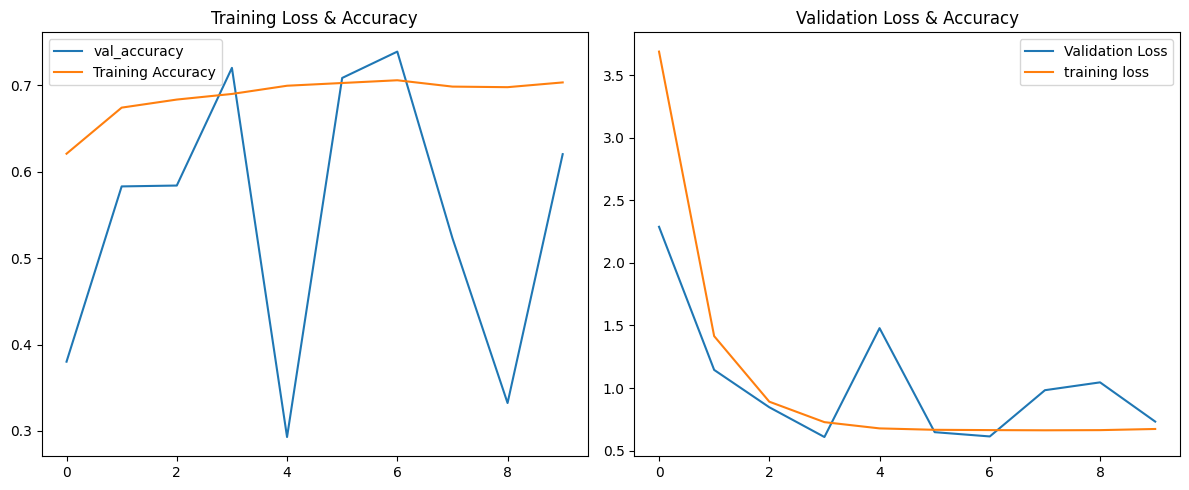

In [58]:
# Create a single figure with two subplots, arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss and validation loss in the first subplot
ax1.plot(tuned_history_resnet.history['val_accuracy'], label='val_accuracy')
ax1.plot(tuned_history_resnet.history['accuracy'], label='Training Accuracy')
ax1.set_title('Training Loss & Accuracy')
ax1.legend()

# Plot training accuracy and validation accuracy in the second subplot
ax2.plot(tuned_history_resnet.history['val_loss'], label='Validation Loss')
ax2.plot(tuned_history_resnet.history['loss'], label='training loss')
ax2.set_title('Validation Loss & Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

####Conclusion
 We used data augmented dataset for this project and for tuning, additional layers were added and  the model accuracy is below

Model Accuracy is ~70% <br />
Model Validation Accuracy is ~62%
After tuning the parameters of ResNet50, we can see that the validation Accuracy has decreased.

#### Step 2. Apply transfer learning model for classification.

####Note,
We have already used transfer learning concept to train the model in previous teps, so we would like to take the oppertunity to use some other model to train our model with transfer learning concept.

In [59]:
# Trying EfficientNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


# Load the EfficientNetB0 model pre-trained on ImageNet data
tl_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for l in tl_base_model.layers[:-20]:
    l.trainable=False

# Add custom classification layers on top of the base model
x = tl_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(1, activation='sigmoid')(x)  # For binary classification

# Create the final model
tl_model = Model(inputs=tl_base_model.input, outputs=predictions)

tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [60]:
# Compile the model with binary cross-entropy loss and an optimizer
tl_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


In [61]:
# Train the model on the dataset
tl_history = tl_model.fit(datagen.flow(X_train[:6000], y_train[:6000], batch_size=10), epochs=10, validation_data=(X_test[:6000], y_test[:6000]))


Epoch 1/10
600/600 [==============================] - 79s 114ms/step - loss: 0.6930 - accuracy: 0.5573 - val_loss: 0.6317 - val_accuracy: 0.7202
Epoch 2/10
600/600 [==============================] - 64s 106ms/step - loss: 0.6861 - accuracy: 0.5708 - val_loss: 0.6365 - val_accuracy: 0.7202
Epoch 3/10
600/600 [==============================] - 64s 106ms/step - loss: 0.6844 - accuracy: 0.5747 - val_loss: 0.6474 - val_accuracy: 0.7202
Epoch 4/10
600/600 [==============================] - 64s 106ms/step - loss: 0.6834 - accuracy: 0.5760 - val_loss: 0.6380 - val_accuracy: 0.7202
Epoch 5/10
600/600 [==============================] - 64s 107ms/step - loss: 0.6833 - accuracy: 0.5760 - val_loss: 0.6599 - val_accuracy: 0.7202
Epoch 6/10
600/600 [==============================] - 64s 107ms/step - loss: 0.6829 - accuracy: 0.5765 - val_loss: 0.6452 - val_accuracy: 0.7202
Epoch 7/10
600/600 [==============================] - 64s 106ms/step - loss: 0.6826 - accuracy: 0.5757 - val_loss: 0.6434 - val_ac

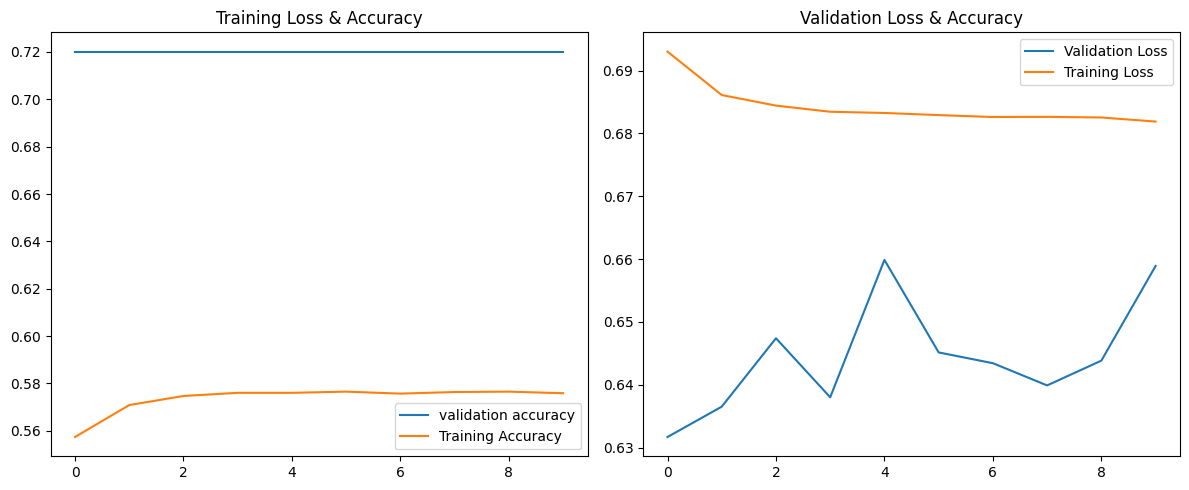

In [62]:
# Create a single figure with two subplots, arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss and validation loss in the first subplot
ax1.plot(tl_history.history['val_accuracy'], label='validation accuracy')
ax1.plot(tl_history.history['accuracy'], label='Training Accuracy')
ax1.set_title('Training Loss & Accuracy')
ax1.legend()

# Plot training accuracy and validation accuracy in the second subplot
ax2.plot(tl_history.history['val_loss'], label='Validation Loss')
ax2.plot(tl_history.history['loss'], label='Training Loss')
ax2.set_title('Validation Loss & Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

####MobileNetV2,
Using MobileNetV2 to see if there is any improvemnet over ResNet50 and EfficientNetB0.

In [63]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the MobileNetV2 model pre-trained on ImageNet data
mn_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in mn_base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
x = GlobalAveragePooling2D()(mn_base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

mn_model = Model(inputs=mn_base_model.input, outputs=predictions)

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = Adam(learning_rate=0.0001)
mn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
mn_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [64]:
# Train the model on the dataset
mn_history = mn_model.fit(datagen.flow(X_train[:6000], y_train[:6000], batch_size=10), epochs=10, validation_data=(X_test[:6000], y_test[:6000]))


Epoch 1/10
600/600 [==============================] - 70s 112ms/step - loss: 0.5608 - accuracy: 0.7233 - val_loss: 0.5354 - val_accuracy: 0.7375
Epoch 2/10
600/600 [==============================] - 62s 103ms/step - loss: 0.5176 - accuracy: 0.7527 - val_loss: 0.5195 - val_accuracy: 0.7473
Epoch 3/10
600/600 [==============================] - 62s 103ms/step - loss: 0.5070 - accuracy: 0.7593 - val_loss: 0.4936 - val_accuracy: 0.7682
Epoch 4/10
600/600 [==============================] - 62s 104ms/step - loss: 0.4958 - accuracy: 0.7610 - val_loss: 0.4642 - val_accuracy: 0.7778
Epoch 5/10
600/600 [==============================] - 62s 104ms/step - loss: 0.4899 - accuracy: 0.7695 - val_loss: 0.4849 - val_accuracy: 0.7690
Epoch 6/10
600/600 [==============================] - 62s 103ms/step - loss: 0.4908 - accuracy: 0.7637 - val_loss: 0.4981 - val_accuracy: 0.7607
Epoch 7/10
600/600 [==============================] - 62s 103ms/step - loss: 0.4789 - accuracy: 0.7730 - val_loss: 0.4711 - val_ac

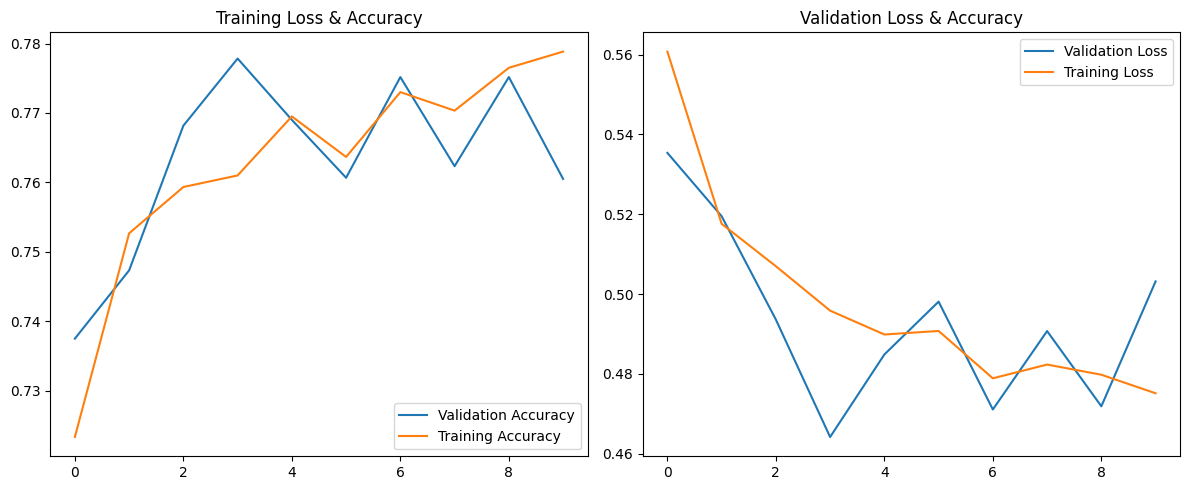

In [65]:
# Create a single figure with two subplots, arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss and validation loss in the first subplot
ax1.plot(mn_history.history['val_accuracy'], label='Validation Accuracy')
ax1.plot(mn_history.history['accuracy'], label='Training Accuracy')
ax1.set_title('Training Loss & Accuracy')
ax1.legend()

# Plot training accuracy and validation accuracy in the second subplot
ax2.plot(mn_history.history['val_loss'], label='Validation Loss')
ax2.plot(mn_history.history['loss'], label='Training Loss')
ax2.set_title('Validation Loss & Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

####Adding Comparison bar chart among all CNN Models variations which we have used in this project.

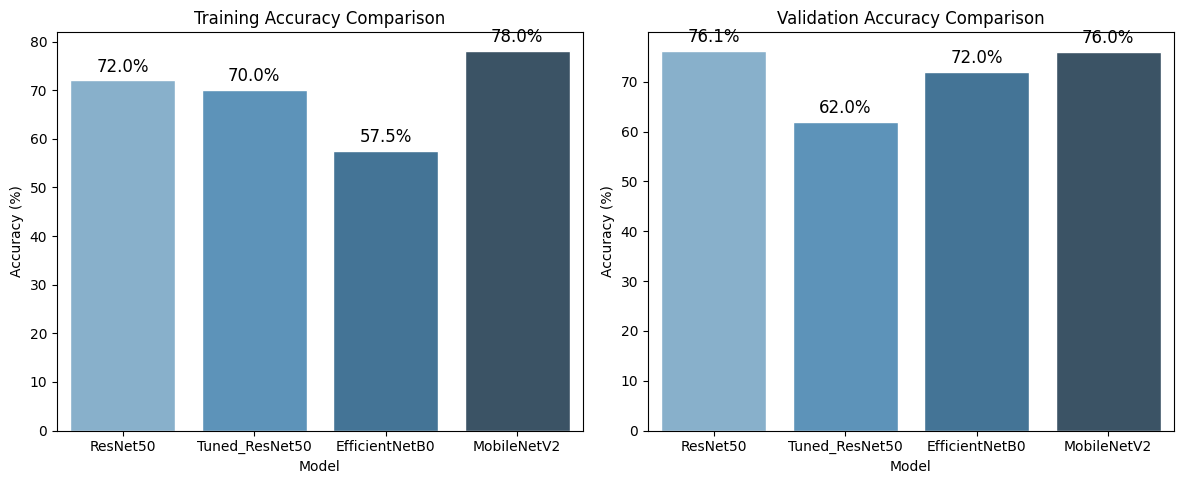

In [89]:
# Create a DataFrame with model names and accuracies
# training data points
training_data = {
    'Model': ['ResNet50', 'Tuned_ResNet50', 'EfficientNetB0', 'MobileNetV2'],
    'Accuracy': [72, 70, 57.5, 78]
}
df1 = pd.DataFrame(training_data)

# validation data points
validation_data = {
    'Model': ['ResNet50', 'Tuned_ResNet50', 'EfficientNetB0', 'MobileNetV2'],
    'Accuracy': [76.1, 62, 72, 76]
}
df2 = pd.DataFrame(validation_data)

# Create a bar plot using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.set(style="whitegrid")

# Training Accuracy Comparison
ax1 = sns.barplot(x="Model", y="Accuracy", data=df1, palette="Blues_d", ax=ax1)
ax1.set(ylabel="Accuracy (%)", title="Training Accuracy Comparison")

# Add data labels on the bars
for p1 in ax1.patches:
    ax1.annotate(f'{p1.get_height()}%', (p1.get_x() + p1.get_width() / 2., p1.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Validation Accuracy Comparison
ax2 = sns.barplot(x="Model", y="Accuracy", data=df2, palette="Blues_d", ax=ax2)
ax2.set(ylabel="Accuracy (%)", title="Validation Accuracy Comparison")

# Add data labels on the bars
for p2 in ax2.patches:
    ax2.annotate(f'{p2.get_height()}%', (p2.get_x() + p2.get_width() / 2., p2.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()

#####Note:
We can see clear evidence from the comparison chart, MobileNetV2 model is giving us very good results. Will evaluate MobileNetV2 with unknown data.

####Evaluate MobileNetV2,
Evaluating MobileNetV2 model with unknown Image to check how it is reacting with new or unknown images.

In [67]:
# unknown sample images for Pneumonia detection
image_with_pneumonia = '/tmp/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'
image_without_pneumonia = '/tmp/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'

print("With Pneumonia:", image_with_pneumonia,"\nWithout Pneumonia: ",image_without_pneumonia)

With Pneumonia: /tmp/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm 
Without Pneumonia:  /tmp/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm


In [68]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


# Load and preprocess the unknown image

# Pneumonia is not present
# image_filepath = image_with_pneumonia

# Pneumonia is present
image_filepath = image_without_pneumonia

# Load and preprocess the DICOM image
dcm_fdata = dcm.read_file(image_filepath)

# You may need to extract the pixel data and convert it to an array
image_data = dcm_fdata.pixel_array

# Resize image to 224x224
img = cv2.resize(image_data, (224, 224))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

chest_xray = img

img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

# Make predictions
predictions = mn_model.predict(img)

predictions, img.shape


1/1 [==============================] - 1s 845ms/step


(array([[0.8877876]], dtype=float32), (1, 224, 224, 3))

Predicted class: Pneumonia Present
Confidence: 0.8877875804901123


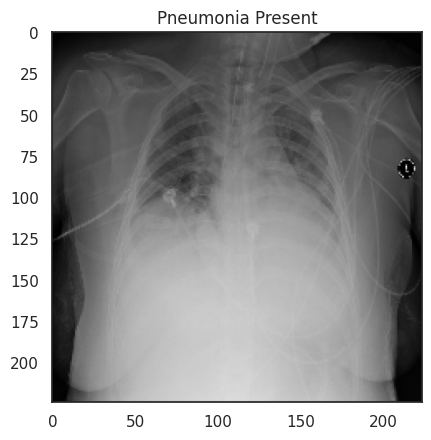

In [69]:
# predicted probability
predicted_probability = predictions[0][0]

# Define a threshold (you can adjust this value)
threshold = 0.5

# Interpret the prediction
if predicted_probability > threshold:
    prediction_label = "Pneumonia Present"
else:
    prediction_label = "No Pneumonia"

# Print the result
print(f"Predicted class: {prediction_label}")
print(f"Confidence: {predicted_probability}")

sns.set(style="white")
plt.title(prediction_label)
plt.imshow(chest_xray)

####<h2>Conclusion</h2>
Model Accuracy is looks good on the sample data.

Model Accuracy of MobileNetV2 is ~77% <br />
Model Validation Accuracy of MobileNetV2 is ~77%

MobileNetV2 model look more appealing to me. It is giving more convincing results. Which accuracy is more close to the existing solution of pneumonia detection.

I have used couple of sample unkown images with Pneumonia or without Pneumonia to check if our model ig giving us correct detection result or not. I am getting good results here too.
1. <strong>With Pneumonia:</strong> /content/drive/MyDrive/Capstone/Pneumonia/Data/CV capstone/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
2. <strong>Without Pneumonia:</strong>  /content/drive/MyDrive/Capstone/Pneumonia/Data/CV capstone/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm

See results of the two above cells, we can just comment and uncomment the lines to check the detection results.

#### Step 3. Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest.

The first step in RCNN is Selective search. Lets initialize Selective search using createSelectiveSearchSegmentation() class of opencv library.

In [31]:
cv2.setUseOptimized(True);
ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Set one image as the base for selective search using setBaseImage(image)

Selective search segmentation function uses hierarchical clustering to group pixels and then combine them into one based on color, texture or composition. The following is an implementation of the search code on the base image.

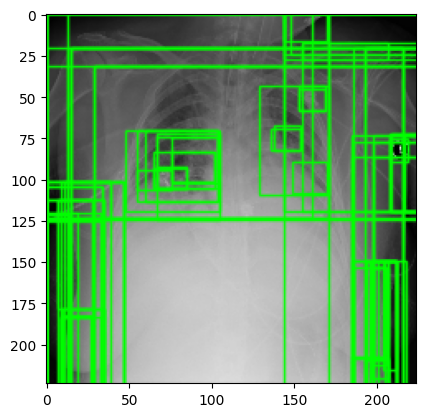

In [32]:
input_image = resized_images[4]
ss_object.setBaseImage(input_image)
ss_object.switchToSelectiveSearchFast()  #this method of createSelectiveSearchSegmentation()
rects = ss_object.process()    # The output of the process is a set of a potential ROI’s, depending on the size of the base image
new_input_image = input_image.copy() # create copy of the base image
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(new_input_image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(new_input_image)

Loop over the image folder and set each image one by one as the base for selective search using setBaseImage(image) and get the proposed regions

Initialising fast selective search and getting proposed regions using class switchToSelectiveSearchFast() and process().

Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.

Now as one image can have many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

In [53]:
train_data=[]
train_labels_data=[]

In [54]:
def calculate_iou(bb_1, bb_2):
    '''
  Now we are initialising the function to calculate IOU (Intersection Over Union)
  of the ground truth box from the box computed by selective search.
  To divide the generated ROI’s, for example, we can use a metric called IoU.
  It’s defined as the intersection area divided by area of the union of a predicted
  bounding box and ground-truth box.
  '''

    #assert bb_1['x1'] < bb_1['x2']    # The assert keyword lets you test if a condition in your code returns True,
    #assert bb_1['y1'] < bb_1['y2']    # if not, the program will raise an AssertionError.
    #assert bb_2['x1'] < bb_2['x2']
    #assert bb_2['y1'] < bb_2['y2']

    x_left = max(bb_1['x1'], bb_2['x1'])
    y_top = max(bb_1['y1'], bb_2['y1'])
    x_right = min(bb_1['x2'], bb_2['x2'])
    y_bottom = min(bb_1['y2'], bb_2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)

    bb_1_area = (bb_1['x2'] - bb_1['x1']) * (bb_1['y2'] - bb_1['y1'])
    bb_2_area = (bb_2['x2'] - bb_2['x1']) * (bb_2['y2'] - bb_2['y1'])

    iou_value = intersection / float(bb_1_area + bb_2_area - intersection)
    #assert iou_value >= 0.0
    #assert iou_value <= 1.0
    return iou_value

In [55]:
MAX_REGION_PROPOSALS = 2000

In [56]:
for i, e in enumerate(resized_images[:500]):
  image = resized_images[i]
  #print(i)
  coordinates=[]
  x1 = pneumonia_df['x'][i]*(224.0/1024.0)
  y1 = pneumonia_df['y'][i]*(224.0/1024.0)
  x2 = pneumonia_df['width'][i]*(224.0/1024.0)
  y2 = pneumonia_df['height'][i]*(224.0/1024.0)
  coordinates.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
  ss_object.setBaseImage(image)
  ss_object.switchToSelectiveSearchFast()
  ss_results = ss_object.process()
  image_new = image.copy()
  min_positive_samples = 0
  min_negative_samples = 0
  flag = 0
  foreground_flag = 0
  background_flag = 0
  for region,ss_coordinate in enumerate(ss_results):
    #print(region)
    if region < MAX_REGION_PROPOSALS and flag == 0:  # Iterating over all the first 2000 results only which are passed by selective search
      for value in coordinates:
        x,y,w,h = ss_coordinate
        iou = calculate_iou(value,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
        if min_positive_samples < 30:
          if iou > 0.70:
            mobile_obj_img = image_new[y:y+h,x:x+w]
            resized_image_2 = cv2.resize(mobile_obj_img, (224,224), interpolation = cv2.INTER_AREA)
            train_data.append(resized_image_2)
            train_labels_data.append(1)
            min_positive_samples += 1
        else :
              foreground_flag = 1
        if min_negative_samples < 30:
          if iou < 0.3:
                  mobile_obj_img = image_new[y:y+h,x:x+w]
                  resized_image_2 = cv2.resize(mobile_obj_img, (224,224), interpolation = cv2.INTER_AREA)
                  #print(resized_image_2.shape)
                  train_data.append(resized_image_2)
                  #print(train_data)
                  train_labels_data.append(0)
                  min_negative_samples += 1
        else :
                    background_flag = 1
      if foreground_flag == 1 and background_flag == 1:
                      print("inside")
                      flag = 1

Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model.

In [37]:
# Trying VGG16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [38]:
# Using VGG16 as a base model
vgg_model = VGG16(weights='imagenet', include_top=True)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In this part in the loop we are freezing the first 15 layers of the model. After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical. Finally the summary of the model is printed using summary() method of keras.

In [39]:
for layers in (vgg_model.layers)[:15]:
    print(layers)
    layers.trainable = False

In [40]:
x = vgg_model.layers[-2].output

In [41]:
x = Dense(2, activation="softmax")(x)

In [42]:
model = Model(inputs = vgg_model.input, outputs = x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
opt = Adam(learning_rate=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [57]:
train_data[0].shape

(224, 224, 3)

In [58]:
len(train_labels_data)

6752

train_data=[] will contain all the images and train_labels_data=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [59]:
# define independent and target features
X = np.array(train_data)
y = np.array(train_labels_data)

In [60]:
X.shape

(6752, 224, 224, 3)

In [61]:
y.shape

(6752,)

In [62]:
from sklearn.preprocessing import LabelBinarizer
class My_Label_Binarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [63]:
lb_object = My_Label_Binarizer()
Y =  lb_object.fit_transform(y)

In [73]:
Y[25]

array([0, 1])

In [64]:
X_train, X_test , y_train, y_test = train_test_split(X , Y, test_size = 0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6076, 224, 224, 3) (676, 224, 224, 3) (6076, 2) (676, 2)


Now we start the training of the model using fit() method.

In [65]:
rcnn_history = model.fit(X_train, y_train, steps_per_epoch=5, epochs=2, validation_split = 0.2)

Epoch 1/2
5/5 [==============================] - 21s 1s/step - loss: 0.1472 - accuracy: 0.9383 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
5/5 [==============================] - 3s 699ms/step - loss: 0.0393 - accuracy: 0.9996 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


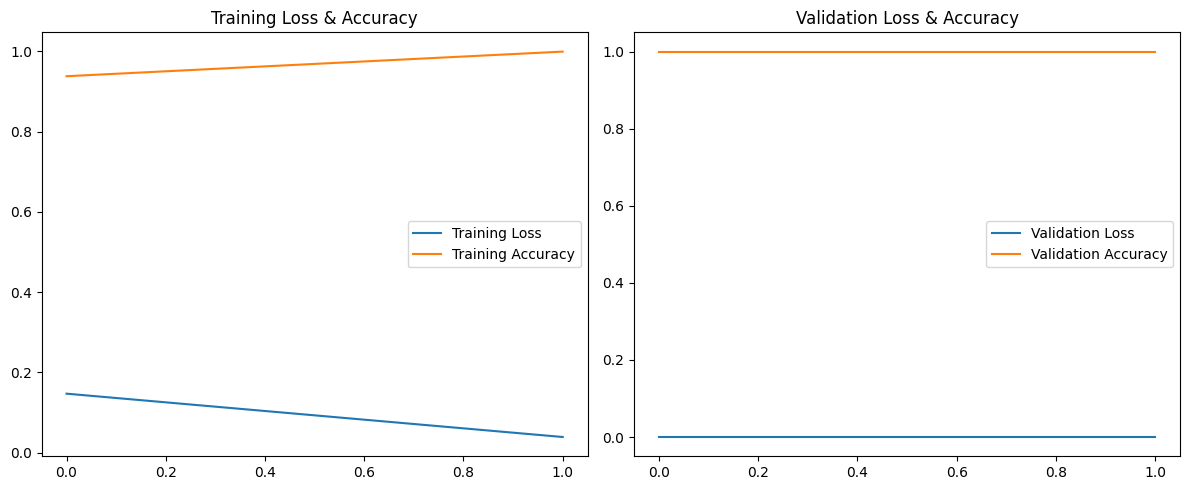

In [66]:
# Create a single figure with two subplots, arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss and validation loss in the first subplot
ax1.plot(rcnn_history.history['loss'], label='Training Loss')
ax1.plot(rcnn_history.history['accuracy'], label='Training Accuracy')
ax1.set_title('Training Loss & Accuracy')
ax1.legend()

# Plot training accuracy and validation accuracy in the second subplot
ax2.plot(rcnn_history.history['val_loss'], label='Validation Loss')
ax2.plot(rcnn_history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Validation Loss & Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


In [67]:
X_test[0]

array([[[11, 11, 11],
        [ 5,  5,  5],
        [ 4,  4,  4],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[10, 10, 10],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [18, 18, 18]],

       [[10, 10, 10],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [17, 17, 17],
        [15, 15, 15],
        [15, 15, 15]],

       ...,

       [[17, 17, 17],
        [19, 19, 19],
        [27, 27, 27],
        ...,
        [52, 52, 52],
        [57, 57, 57],
        [57, 57, 57]],

       [[15, 15, 15],
        [22, 22, 22],
        [25, 25, 25],
        ...,
        [52, 52, 52],
        [61, 61, 61],
        [74, 74, 74]],

       [[16, 16, 16],
        [24, 24, 24],
        [23, 23, 23],
        ...,
        [72, 72, 72],
        [92, 92, 92],
        [89, 89, 89]]], dtype=uint8)

In [69]:
model.predict(X_test[0:10])

1/1 [==============================] - 1s 594ms/step


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [70]:
y_test[0:10]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

The above detail shows that the RCNN model can classify for the given image samples whether it has pneumonia or not 100%

#### Step 4. Pickle the model for future prediction.

In [ ]:
import pickle

# Save the ResNet50 model to a file
model_filename = '/content/drive/MyDrive/Capstone/Pneumonia/pickle/resnet50_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model_resnet, model_file)

# Save the ResNet50 model to a file
tuned_model_filename = '/content/drive/MyDrive/Capstone/Pneumonia/pickle/tuned_resnet50_model.pkl'
with open(tuned_model_filename, 'wb') as model_file:
    pickle.dump(tuned_model_resnet, model_file)

# Save the efficient model to a file
efficientnet_model_filename = '/content/drive/MyDrive/Capstone/Pneumonia/pickle/efficientnet_model.pkl'
with open(efficientnet_model_filename, 'wb') as model_file:
    pickle.dump(tl_model, model_file)


In [88]:
import pickle
# Save the efficient model to a file
rcnn_model_filename = '/content/drive/MyDrive/rcnn_model.pkl'
with open(rcnn_model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

#### Step 5. Final Report.

Final report will be attached in the form of pdf.